In [1]:
import numpy as np
import matplotlib.pylab as plt
import blimpy as bl
%matplotlib inline

In [2]:
from typing import List, Tuple

from astropy.time import Time
from astropy import units as u

In [3]:
MAX_IMSHOW_POINTS   = (8192, 4096)           # Max number of points in imshow plot


def plot_waterfall(fil, f_start=None, f_stop=None, if_id=0, 
                   logged=True, cb=False, freq_label=False, MJD_time=False, **kwargs):
    """ Plot waterfall of data
    Args:
        f_start (float): start frequency, in MHz
        f_stop (float): stop frequency, in MHz
        logged (bool): Plot in linear (False) or dB units (True),
        cb (bool): for plotting the colorbar
        kwargs: keyword args to be passed to matplotlib imshow()
    """


    plt.rc('font', size=12)

    plot_f, plot_data = fil.grab_data(f_start, f_stop, if_id)

    # Make sure waterfall plot is under 4k*4k
    dec_fac_x, dec_fac_y = 1, 1
    if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
        dec_fac_x = plot_data.shape[0] / MAX_IMSHOW_POINTS[0]

    if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
        dec_fac_y =  plot_data.shape[1] /  MAX_IMSHOW_POINTS[1]

    #print(dec_fac_x)
        
    plot_data = bl.utils.rebin(plot_data, int(dec_fac_x), int(dec_fac_y))
    
    plot_data = np.fliplr(plot_data)
    plot_f = np.flipud(plot_f)

    if MJD_time:
        extent=(plot_f[0], plot_f[-1], fil.timestamps[-1], fil.timestamps[0])
    else:
        extent=(plot_f[0], plot_f[-1], (fil.timestamps[-1]-fil.timestamps[0])*24.*60.*60, 0.0)

    this_plot = plt.imshow(plot_data,
        aspect='auto',
        rasterized=True,
        interpolation='nearest',
        extent=extent,
        cmap='hot',
        **kwargs
    )
    if cb:
        plt.colorbar()

    if freq_label:
        plt.xlabel("Frequency (Hz)")
    if MJD_time:
        plt.ylabel("Time (MJD)")
    else:
        plt.ylabel("Time (s)")

#    print('this is plot_data:', plot_data)
#    print('this is plot_data\'s shape:', plot_data.shape)
#    print('this is plot_f:', plot_f)
#    print('this is plot_f\'s shape', plot_f.shape)
    
    return this_plot

def make_waterfall_plots(filenames_list, target, f_start, f_stop, ion=False, correction_in=0, 
                         line1=None, line2=None, **kwargs):
    ''' Makes waterfall plots per group of ON-OFF pairs (up to 6 plots.)
    '''

    plt.rc('font', size=12)

    if ion:
        plt.ion()

    n_plots = len(filenames_list)
    fig = plt.subplots(n_plots, sharex=True, sharey=True)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(10, 2*n_plots))
#    fig = plt.subplots(1, 2, 1, sharex=True, sharey=True)

    fil = bl.Waterfall(filenames_list[0], f_start=f_start, f_stop=f_stop)
    
    A1_avg = np.median(fil.data)
    A1_max = fil.data.max()
    A1_std = np.std(fil.data)

    labeling = ['A','B','A','C','A','D']

    delta_f = np.abs(f_start-f_stop)
    mid_f = np.abs(f_start+f_stop)/2.
    
    #Adjust the incorrect header data
    correction = mid_f - correction_in
    mid_f_text = mid_f - correction

    for i,filename in enumerate(filenames_list):
        plt.subplot(n_plots, 2, (2 * i) + 1)

        fil = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop)

        this_plot = plot_waterfall(fil,f_start=f_start, f_stop=f_stop,
                                   vmin=A1_avg-A1_std*0,vmax=A1_avg+5.*A1_std,**kwargs)
        
        if line1 != None:
            plt.axvline(x=line1, color = 'white', ls='--')
        if line2 != None:
            plt.axvline(x=line2, color = 'white', ls='--')

        if i == 0:
            plt.title('Waterfall')

        if i < len(filenames_list)-1:
            plt.xticks(np.arange(f_start, f_stop, delta_f/4.), ['','','',''])

    #Some plot formatting.
    ax = plt.gca()
    #ax.invert_xaxis()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    if target == 'HIP7981':
        #f_start -= 0.3
        #f_stop  += 0.3
        factor = 1e3
        units = 'kHz'
    else:
        factor = 1e6
        units = 'Hz'
    
    plt.xticks(np.arange(f_start, f_stop + delta_f/4, delta_f/4),
               [round(loc_freq) for loc_freq in np.arange(
                   (f_start-mid_f), (f_stop+delta_f/4-mid_f), delta_f/4)*factor])
    plt.xlabel("Relative frequency in %s from %f MHz"%(units, mid_f))
    

    #to plot color bar. for now.
#    cax = fig[0].add_axes([0.9, 0.12, 0.03, 0.75])
#    fig[0].colorbar(this_plot,cax=cax,label='Power (Arbitrary Units)')

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
#    plt.subplots_adjust(hspace=0,wspace=0)

In [4]:
def make_waterfall_plots_full(filenames_list, target, f_start, f_stop, ion=False, correction_in=0, 
                              line1=None, line2=None, **kwargs):
    ''' Makes waterfall plots per group of ON-OFF pairs (up to 6 plots.)
    '''

    plt.rc('font', size=12)

    if ion:
        plt.ion()

    n_plots = len(filenames_list)
    fig = plt.subplots(n_plots, sharex=True, sharey=True)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(10, 2*n_plots))
#    fig = plt.subplots(1, 2, 1, sharex=True, sharey=True)

    fil = bl.Waterfall(filenames_list[0], f_start=f_start, f_stop=f_stop)
    
    A1_avg = np.median(fil.data)
    A1_max = fil.data.max()
    A1_std = np.std(fil.data)

    labeling = ['A','B','A','C','A','D']

    delta_f = np.abs(f_start-f_stop)
    mid_f = np.abs(f_start+f_stop)/2.
    
    #Adjust the incorrect header data
    correction = mid_f - correction_in
    mid_f_text = mid_f - correction

    for i,filename in enumerate(filenames_list):
        plt.subplot(n_plots, 1, i + 1)

        fil = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop)

        this_plot = plot_waterfall(fil,f_start=f_start, f_stop=f_stop,
                                   vmin=A1_avg-A1_std*0,vmax=A1_avg+5.*A1_std,**kwargs)
        
        if line1 != None:
            plt.axvline(x=line1, color = 'white', ls='--')
        if line2 != None:
            plt.axvline(x=line2, color = 'white', ls='--')

##        if i == 0:
##            plt.title('Waterfall')

        if i < len(filenames_list)-1:
            plt.xticks(np.arange(f_start, f_stop, delta_f/4.), ['','','',''])

    #Some plot formatting.
    ax = plt.gca()
    #ax.invert_xaxis()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    if target == 'HIP7981':
        #f_start -= 0.3
        #f_stop  += 0.3
        factor = 1e3
        units = 'kHz'
    else:
        factor = 1e6
        units = 'Hz'
    
    plt.xticks(np.arange(f_start, f_stop + delta_f/4, delta_f/4),
               [round(loc_freq) for loc_freq in np.arange(
                   (f_start-mid_f), (f_stop+delta_f/4-mid_f), delta_f/4)*factor])
    plt.xlabel("Relative frequency in %s from %f MHz"%(units, mid_f))
    

    #to plot color bar. for now.
#    cax = fig[0].add_axes([0.9, 0.12, 0.03, 0.75])
#    fig[0].colorbar(this_plot,cax=cax,label='Power (Arbitrary Units)')

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
#    plt.subplots_adjust(hspace=0,wspace=0)

In [5]:
TELESCOPE = 'GBT'
OBS_TIME = '300s x 3'

In [6]:
all_targets = []

f = open('result_3_filenames.txt', 'r')
text = f.read().split()
f.close()

for word in text:
    if 'directory' not in word and '.csv' in word:
        all_targets.append(word[:-6])

In [7]:
# all_targets = []

# f = open('result_3_filenames.txt', 'r')
# text = f.read().split()
# f.close()

# for word in text:
#    if 'directory' not in word and '.csv' in word:
#        if '_0' in word:
#            all_targets.append(word[:-6])
#        else:
#            all_targets.append(word[:-4])

In [8]:
all_targets

['GJ905',
 'HIP100859',
 'HIP108092',
 'HIP11029',
 'HIP110750',
 'HIP113718',
 'HIP116106',
 'HIP118162',
 'HIP13402',
 'HIP1368',
 'HIP15638',
 'HIP21029',
 'HIP21402',
 'HIP21547',
 'HIP22762',
 'HIP27803',
 'HIP2',
 'HIP33955',
 'HIP34115',
 'HIP36915',
 'HIP4151',
 'HIP43557',
 'HIP46549',
 'HIP50583',
 'HIP53910',
 'HIP63762',
 'HIP77725',
 'HIP86201',
 'HIP97222',
 'HIP99031']

In [9]:
print(len(all_targets))

30


In [10]:
def get_cadence(target_name: str) -> List[str]:
    
    cadence = []
    
    filename = 'result_3/' + target_name + '_directory_5.csv'
        
    f = open(filename, 'r')

    lines = f.readlines()
    f.close()

    for line in lines[1:]:
        info = line.strip().split(',')
        h5file = info[1][12:]
        cadence.append(h5file)
    
    return cadence

In [11]:
def get_hits(target_name: str) -> List[List[float]]:
    
    hits = []

    filename = 'result_3/' + target_name + '_0.csv'
    f = open(filename, 'r')

    lines = f.readlines()
    f.close()

    for line in lines[1:]:
        info = line.strip().split(',')
        start = float(info[1])
        stop = float(info[2])
        fit = float(info[3])
        hits.append([start, stop, fit])

    return hits

In [12]:
class Target:
    
    
    def __init__(self, target_name: str) -> None:
        
        self.name = target_name
        self.cadence = get_cadence(target_name)
        self.hits = get_hits(target_name)
        self.num_hits = len(self.hits)
    
    def __str__(self) -> str:
        
        if self.num_hits == 1:
            return 'Target {} with {} hit'.format(self.name, self.num_hits)
        
        return 'Target {} with {} hits'.format(self.name, self.num_hits)
    
    
    def get_cadence_type(self) -> str:
        
        if len(self.cadence) == 6:
        
            lst = []

            for i in range(len(self.cadence)):
                fb = bl.Waterfall(self.cadence[i], load_data=False)
                source = fb.header['source_name']
                lst.append(source)

            if lst[0] == lst[2] == lst[4]:
                
                if lst[1] == lst[3] == lst[5] \
                and lst[0] != lst[1]:
                    return 'ABABAB'
                          
                elif lst[1] != lst[3] and lst[1] != lst[5] and lst[3] != lst[5] \
                and lst[0] != lst[1] and lst[0] != lst[3] and lst[0] != lst[5]:
                    return 'ABACAD'
        
        return 'other'
    
    
    def get_RA(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        RA = fb.header['src_raj']
        
        return str(RA)
    
    
    def get_DEC(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        DEC = fb.header['src_dej']
        
        return str(DEC)
    
    
    def get_date_time(self, ISOT=True) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        mjd = fb.header['tstart']
        
        if ISOT:
            return Time(mjd, format='mjd').isot
        
        return str(mjd)
    
    
    def get_min_freq(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        
        if fb.header['foff'] < 0:
            min_freq = fb.container.f_start - fb.header['foff']
        else:
            min_freq = fb.container.f_start
        
        return str(min_freq) + ' MHz'
    

    def get_max_freq(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        
        if fb.header['foff'] < 0:
            max_freq = fb.container.f_stop

        else:
            max_freq = fb.container.f_stop - fb.header['foff']
        
        return str(max_freq) + ' MHz'

In [13]:
COLUMN = 52

In [14]:
class Hit:
    
    
    def __init__(self, target: Target, index: int) -> None:
        
        self.target = target
        self.target_name = target.name
        self.number = index + 1
        self.start_freq = target.hits[index][0]
        self.end_freq = target.hits[index][1]
        self.fit = target.hits[index][2]
    
    def __str__(self) -> str:
        
        return 'Hit {} of {} for target {}'.format(self.number, self.target.num_hits, self.target_name)
    
    
    def make_plot(self):
        
        plt.rc('font', size=10)
        
        mid_freqs_pink = []
        fits_pink = []
        
        for i in range(self.target.num_hits):

            mid_freq = (self.target.hits[i][0] + self.target.hits[i][1]) / 2
            fit = self.target.hits[i][2]
            
            mid_freqs_pink.append(mid_freq)
            fits_pink.append(fit)
        
        marker_size = 4 / (self.target.num_hits / 5000)
        
        plt.scatter(mid_freqs_pink, fits_pink, color='pink', marker='.', s=marker_size)
        
        mid = (self.start_freq + self.end_freq) / 2
        plt.plot(mid, self.fit, marker='o', color='red', ms=8)
        
        plot_start = float(self.target.get_min_freq()[:-4])
        plot_end = float(self.target.get_max_freq()[:-4])
        plt.xlim(plot_start, plot_end)
        
        plt.grid()
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('Fit')
        plt.title('Position of hit in the frequency band')
        
    
    def get_ID(self, targets_list: List[str]) -> str:
        
        first = str(targets_list.index(self.target_name) + 1)
        second = str(self.number)
        
        ID = first.rjust(2, '0') + '-' + second.rjust(5, '0')
        
        return ID
        

    def print_info(self, targets_list) -> None:
        
        s1 = 'Target name: ' + self.target_name
        s2 = 'Number of hits for this target: ' + str(self.target.num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Right ascension: ' + self.target.get_RA()
        s2 = 'Average number of hits per target: ' + str(avg_num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Declination: ' + self.target.get_DEC()
        print(s1)

        s1 = 'Telescope: ' + TELESCOPE
        print(s1)

        s1 = 'Observation start (MJD): ' + self.target.get_date_time(ISOT=False)
        s2 = '\t\tHit #' + str(self.number) + ' of ' + str(self.target.num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Observation start (ISOT): ' + self.target.get_date_time()
        s2 = 'Start frequency: ' + str(self.start_freq) + ' MHz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Observing time: ' + OBS_TIME
        s2 = 'End frequency: ' + str(self.end_freq) + ' MHz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Cadence: ' + self.target.get_cadence_type()
        s2 = 'Event bandwidth: ' + str((self.end_freq - self.start_freq) * 1e6) + ' Hz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Min frequency: ' + self.target.get_min_freq()
        s2 = 'Probability: ' + str(self.fit * 100) + '%'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Max frequency: ' + self.target.get_max_freq()
        s2 = 'Candidate ID: ' + self.get_ID(targets_list)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

In [15]:
num_hits_per_target = []

for target_name in all_targets:
    n = Target(target_name).num_hits
    num_hits_per_target.append(n)

avg_num_hits = np.sum(num_hits_per_target) / len(all_targets)

In [16]:
tab = ' ' * (14 - len('Target index'))

print('Target index', tab, 'Number of hits')

for i, num in enumerate(num_hits_per_target):
    tab = ' ' * (14 - len(str(i)))
    print(i, tab, num)

Target index    Number of hits
0               1359
1               1098
2               1471
3               438
4               1221
5               774
6               847
7               528
8               2226
9               1582
10              1668
11              633
12              416
13              1166
14              427
15              728
16              1296
17              509
18              1164
19              453
20              677
21              807
22              3466
23              710
24              1536
25              2410
26              488
27              427
28              1281
29              757


In [17]:
np.max(num_hits_per_target)

3466

In [28]:
def plot_highlighted_hist(target: Target):

    plt.rc('font', size=10)
    
    binning = np.arange(0, 4000, 200)

    array, bins, patches = plt.hist(num_hits_per_target, bins=binning, color='gray')

    n = target.num_hits // 200
    patches[n].set_fc('red')
    
#    plt.yticks(ticks=[0, 1, 2, 3, 4])
    plt.xticks(ticks=np.arange(0, 4000, 400))

    plt.grid()
    plt.xlabel('Number of hits')
    plt.ylabel('Number of targets')
    plt.title('Hits per target')

In [36]:
# To pick a target, redefine i or directly define target as the corresponding string:
i = 0
target = Target(all_targets[i])
target = Target('HIP2')

In [37]:
target.num_hits

1296

In [38]:
tab = ' ' * (10 - len('Hit index'))
j_list = []

print('Hit index', tab, 'Probability')
for j in range(len(target.hits)):
    if target.hits[j][2] > 0.9:
        tab = ' ' * (10 - len(str(j)))
        j_list.append(j)
        print(j, tab, target.hits[j][2])
print('\nlen =', len(j_list))

Hit index   Probability
713         0.94
715         0.955
716         0.982
723         0.919
730         0.936
737         0.901
739         0.972
743         0.974
744         0.979
747         0.979
748         0.955
749         0.974
780         0.906
954         0.91
962         0.903
994         0.937
1014        0.914
1019        0.914
1053        0.921
1106        0.932
1108        0.964
1121        0.944
1147        0.942
1148        0.946
1152        0.985
1153        0.981
1155        0.957
1156        0.907
1157        0.993
1161        0.901
1163        0.94
1171        0.902
1172        0.91
1194        0.906

len = 34


In [39]:
k = 0

# To pick a hit, redefine j
j = j_list[k]
hit = Hit(target, j)

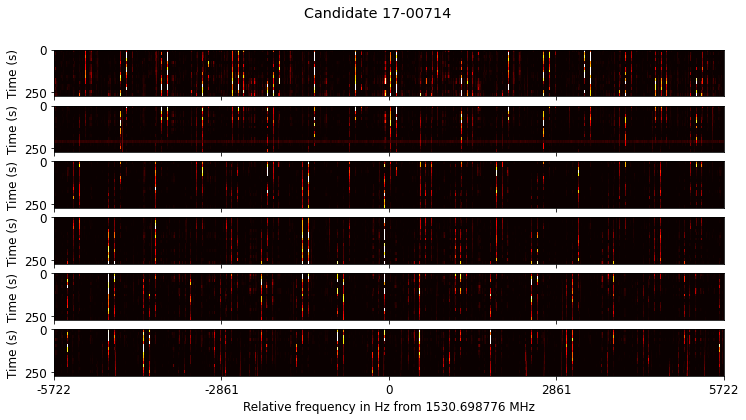

In [40]:
diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(12, 6)  
plt.show()

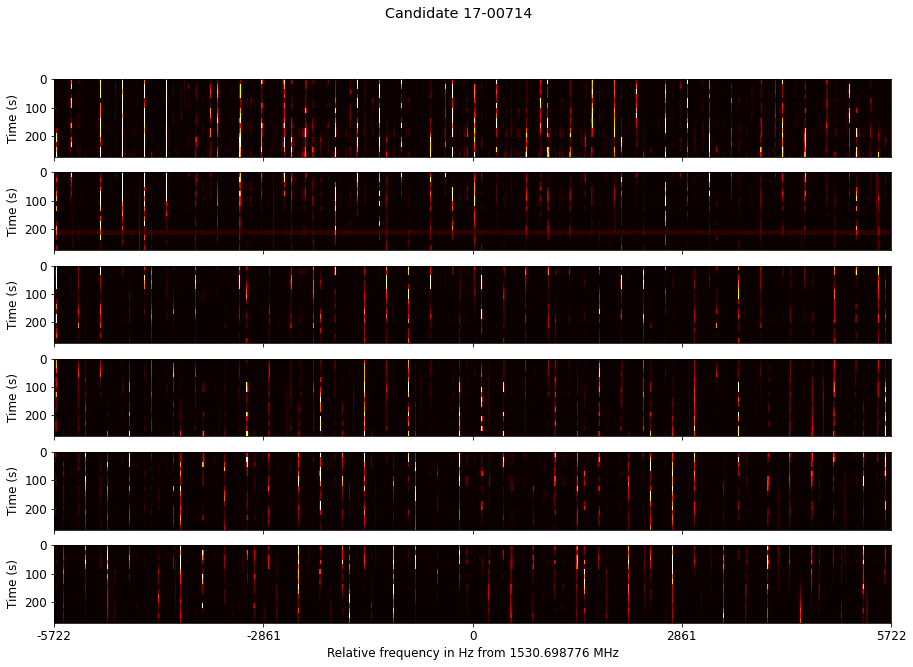

In [41]:
diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(15, 10)    
plt.show()

					Candidate information

Target name: HIP2                                     Number of hits for this target: 1296
Right ascension: 0h00m00.997s                         Average number of hits per target: 1085.4333333333334
Declination: -19d10m45.011s
Telescope: GBT
Observation start (MJD): 57573.58480324074            		Hit #714 of 1296
Observation start (ISOT): 2016-07-04T14:02:07.000     Start frequency: 1530.6930541992188 MHz
Observing time: 300s x 3                              End frequency: 1530.7044982910156 MHz
Cadence: ABACAD                                       Event bandwidth: 11444.091796875 Hz
Min frequency: 1023.9257840439677 MHz                 Probability: 94.0%
Max frequency: 1926.26953125 MHz                      Candidate ID: 17-00714


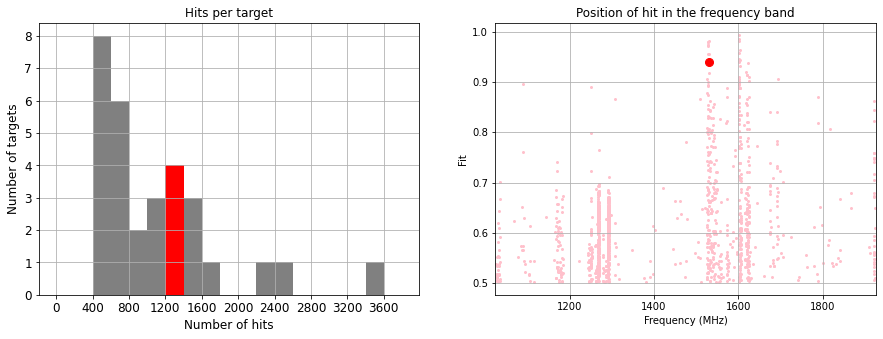

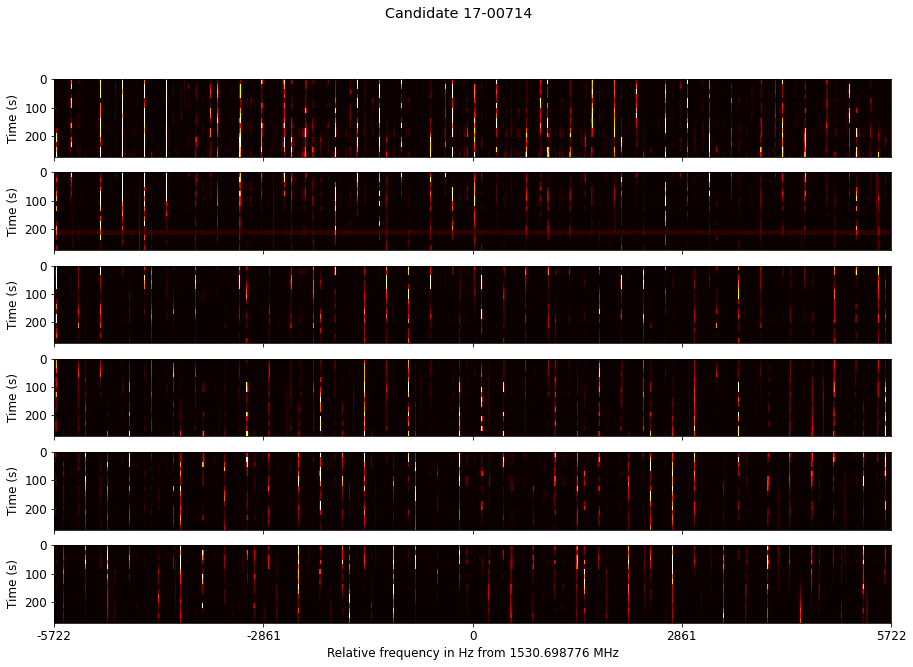

In [42]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


plt.subplot(1, 2, 1)
plot_highlighted_hist(target)

plt.subplot(1, 2, 2)
hit.make_plot()

plt.gcf().set_size_inches(15, 5)    
plt.show()


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(15, 10)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid, 
                     line1=hit.start_freq, line2=hit.end_freq)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq - diff
stop = hit.end_freq + diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid, 
                     line1=hit.start_freq, line2=hit.end_freq)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info()


diff = hit.end_freq - hit.start_freq

start = hit.start_freq - diff
stop = hit.end_freq + diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 10)
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info()


diff = hit.end_freq - hit.start_freq

start = hit.start_freq - diff
stop = hit.end_freq + diff

make_waterfall_plots(filenames_list=target.cadence, target=target.name, f_start=start, f_stop=stop)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 10)
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info()

plt.subplot(1, 2, 1)
plot_highlighted_hist(target)

plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 10)
plt.show()

In [ ]:
diff = hit.end_freq - hit.start_freq

start = hit.start_freq - diff
stop = hit.end_freq + diff

make_waterfall_plots(filenames_list=target.cadence, target=target.name, f_start=start, f_stop=stop)

plt.gcf().set_size_inches(15, 10)
plt.show()

In [ ]:
plt.subplot(2, 2, 1)
hit.print_info()

plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 10)
plt.show()


start = hit.start_freq
stop = hit.end_freq
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid)

In [ ]:
bl.Waterfall(target.cadence[0], f_start=hit.start_freq, f_stop=hit.end_freq)

In [ ]:
help(bl.Waterfall)

À faire:

- Remove space and ticks
- x-axis label
- Add two lines that delimit event
- Add and adjust colorbar